# Clustering Analysis

Visualize sentence embeddings using UMAP and PCA projections, and compute diversity metrics.

**Prerequisites:**
- Run `python scripts/embed_cases.py` to generate embeddings
- Embeddings saved in `data/sentence_embeddings/`

In [1]:
import os
import sys
import pickle
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
import umap

# Add paths for shared imports
REPO_ROOT = Path("../..").resolve()
PROJECT_ROOT = Path("..").resolve()  # 1-dataset-generation
sys.path.insert(0, str(REPO_ROOT))
sys.path.insert(0, str(PROJECT_ROOT))

from setup.plot_config import (
    PASTEL2,
    SET2,
    MODEL_COLORS,
    MODEL_RENAME,
    CHOICE_COLORS,
    set_pub_style,
    save_fig,
)
from scripts.utils.metrics import embedding_diversity_entropy, normalized_volume_ratio

# Set paths
DATA_DIR = Path("../data")
OUTPUT_DIR = Path("../outputs")
FIGURE_DIR = OUTPUT_DIR / "figures"
TABLE_DIR = OUTPUT_DIR / "tables"
FIGURE_DIR.mkdir(parents=True, exist_ok=True)
TABLE_DIR.mkdir(parents=True, exist_ok=True)

# Color palette for plots (change to PASTEL2 or SET2 as needed)
PALETTE = SET2

# Apply publication style
set_pub_style()

/Users/hannahrosekirk/Documents/local_github/relationship-seeking-ai/steering_vecs/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Publication style loaded (font: Arial)


## Load Data

In [2]:
# Load embeddings
embeddings_dir = DATA_DIR / "sentence_embeddings"

# Our dataset
with open(embeddings_dir / "relationship-seeking.pkl", "rb") as f:
    our_data = pickle.load(f)

print(f"Loaded {len(our_data)} embeddings")
our_data.head()

Loaded 5510 embeddings


,row_id,embedding_full_question,embedding_short_question,embedding_choice_matching,embedding_choice_not_matching,embedding_full_choice_matching,embedding_full_choice_not_matching
0,0,"[0.040628377, 0.028634015, -0.025531478, -0.17...","[8.6635606e-05, 0.07279823, -0.04113046, -0.17...","[0.075487815, 0.24959406, -0.036923084, -0.140...","[-0.08902031, 0.18396366, -0.04392368, -0.1015...","[0.075487815, 0.24959406, -0.036923084, -0.140...","[-0.08902031, 0.18396366, -0.04392368, -0.1015..."
1,1,"[0.073003, 0.106116794, -0.03247417, -0.044490...","[0.064887345, 0.12753095, -0.020003153, -0.052...","[0.1040909, 0.20275377, -0.026520284, -0.00478...","[0.002065995, 0.027356178, 0.012399902, -0.030...","[0.1040909, 0.20275377, -0.026520284, -0.00478...","[0.002065995, 0.027356178, 0.012399902, -0.030..."
2,2,"[0.004418432, 0.036462687, -0.03513486, -0.051...","[-0.021881746, 0.07510458, -0.04285319, -0.039...","[-0.07972255, 0.12978657, -0.07662197, -0.0042...","[-0.053965617, 0.18327071, -0.039841168, 0.066...","[-0.07972255, 0.12978657, -0.07662197, -0.0042...","[-0.053965617, 0.18327071, -0.039841168, 0.066..."
3,3,"[0.022279756, -0.06284586, -0.02957421, -0.016...","[0.0096386345, -0.041339792, -0.035345435, -0....","[0.062438868, 0.19841452, -0.08708763, -0.0018...","[-0.01905148, 0.029264117, -0.015318852, 0.006...","[0.062438868, 0.19841452, -0.08708763, -0.0018...","[-0.01905148, 0.029264117, -0.015318852, 0.006..."
4,4,"[0.018942047, -0.08465436, -0.0016464662, -0.0...","[0.01652124, -0.091989025, 0.00617919, -0.0922...","[-0.066881426, -0.06688433, 0.015513576, -0.04...","[-0.03252257, -0.035609048, -0.04535639, 0.076...","[-0.066881426, -0.06688433, 0.015513576, -0.04...","[-0.03252257, -0.035609048, -0.04535639, 0.076..."


In [3]:
def add_projections(
    df, projection="umap", n_components=2, text_col="embedding_full_question"
):
    """
    Add PCA or UMAP projections to the DataFrame based on existing embeddings.
    """
    df = df.copy()
    embeddings = np.vstack(df[text_col])

    if projection == "umap":
        reducer = umap.UMAP(n_neighbors=15, n_components=n_components, random_state=42)
        projection_result = reducer.fit_transform(embeddings)
    elif projection == "pca":
        pca = PCA(n_components=n_components)
        projection_result = pca.fit_transform(embeddings)
    else:
        raise ValueError("Unsupported projection type. Choose 'umap' or 'pca'.")

    df[f"{projection}_1"] = projection_result[:, 0]
    df[f"{projection}_2"] = projection_result[:, 1]

    return df


# Add UMAP and PCA projections to our data
df = add_projections(our_data, projection="pca")
df = add_projections(df, projection="umap")

display(df.head())

/Users/hannahrosekirk/Documents/local_github/relationship-seeking-ai/steering_vecs/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/Users/hannahrosekirk/Documents/local_github/relationship-seeking-ai/steering_vecs/lib/python3.9/site-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)
OMP: Info #271: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


,row_id,embedding_full_question,embedding_short_question,embedding_choice_matching,embedding_choice_not_matching,embedding_full_choice_matching,embedding_full_choice_not_matching,pca_1,pca_2,umap_1,umap_2
0,0,"[0.040628377, 0.028634015, -0.025531478, -0.17...","[8.6635606e-05, 0.07279823, -0.04113046, -0.17...","[0.075487815, 0.24959406, -0.036923084, -0.140...","[-0.08902031, 0.18396366, -0.04392368, -0.1015...","[0.075487815, 0.24959406, -0.036923084, -0.140...","[-0.08902031, 0.18396366, -0.04392368, -0.1015...",-0.204966,-0.161634,8.813011,9.894167
1,1,"[0.073003, 0.106116794, -0.03247417, -0.044490...","[0.064887345, 0.12753095, -0.020003153, -0.052...","[0.1040909, 0.20275377, -0.026520284, -0.00478...","[0.002065995, 0.027356178, 0.012399902, -0.030...","[0.1040909, 0.20275377, -0.026520284, -0.00478...","[0.002065995, 0.027356178, 0.012399902, -0.030...",0.196136,-0.476280,10.884671,4.810956
2,2,"[0.004418432, 0.036462687, -0.03513486, -0.051...","[-0.021881746, 0.07510458, -0.04285319, -0.039...","[-0.07972255, 0.12978657, -0.07662197, -0.0042...","[-0.053965617, 0.18327071, -0.039841168, 0.066...","[-0.07972255, 0.12978657, -0.07662197, -0.0042...","[-0.053965617, 0.18327071, -0.039841168, 0.066...",-0.552925,0.326191,11.779243,9.894432
3,3,"[0.022279756, -0.06284586, -0.02957421, -0.016...","[0.0096386345, -0.041339792, -0.035345435, -0....","[0.062438868, 0.19841452, -0.08708763, -0.0018...","[-0.01905148, 0.029264117, -0.015318852, 0.006...","[0.062438868, 0.19841452, -0.08708763, -0.0018...","[-0.01905148, 0.029264117, -0.015318852, 0.006...",-0.399231,-1.017302,7.350592,13.586033
4,4,"[0.018942047, -0.08465436, -0.0016464662, -0.0...","[0.01652124, -0.091989025, 0.00617919, -0.0922...","[-0.066881426, -0.06688433, 0.015513576, -0.04...","[-0.03252257, -0.035609048, -0.04535639, 0.076...","[-0.066881426, -0.06688433, 0.015513576, -0.04...","[-0.03252257, -0.035609048, -0.04535639, 0.076...",0.300902,0.058106,10.640772,9.358184


---
## Diversity Metrics

Compute embedding diversity metrics (entropy and volume ratio) by different groupings.

In [4]:
def compute_metrics_by_column(df, embedding_column, group_by_column):
    """
    Computes metrics for subsets of a DataFrame grouped by a specific column.
    """
    results = []

    for group in df[group_by_column].dropna().unique():
        subset = df[df[group_by_column] == group].copy()
        if len(subset) == 0:
            continue
        subset = subset.rename(columns={embedding_column: "embedding"})

        entropy = embedding_diversity_entropy(subset)
        volume = normalized_volume_ratio(subset)

        results.append(
            {
                group_by_column: group,
                "Entropy": entropy,
                "Volume": volume,
                "Count": len(subset),
            }
        )

    return pd.DataFrame(results)

### Metrics by Metaprompt Tags

In [5]:
# Load metaprompts to get tags
metaprompts = pd.read_json(DATA_DIR / "metaprompts.jsonl", lines=True)
processed = pd.read_json(
    DATA_DIR / "processed_cases" / "processed_cases.jsonl", lines=True
)

# Merge to get tags and model
merged_df = df.merge(
    processed[["prompt_id", "metaprompt_id", "model"]],
    left_on="row_id",
    right_on="prompt_id",
    how="left",
)
merged_df = merged_df.merge(
    metaprompts[
        ["metaprompt_id", "base_prompt_tag", "prompt_type_tag", "prompt_suffix_tag"]
    ],
    on="metaprompt_id",
    how="left",
)

# Add display names for models
merged_df["model_display"] = (
    merged_df["model"].map(MODEL_RENAME).fillna(merged_df["model"])
)

print(f"Merged data shape: {merged_df.shape}")

Merged data shape: (5510, 18)


In [6]:
# Compute metrics by different groupings
for tag_column in ["base_prompt_tag", "prompt_type_tag", "model"]:
    if tag_column in merged_df.columns:
        print(f"\n=== Metrics by {tag_column} ===")
        metrics_table = compute_metrics_by_column(
            df=merged_df,
            embedding_column="embedding_full_question",
            group_by_column=tag_column,
        )
        print(metrics_table.to_string(index=False))


=== Metrics by base_prompt_tag ===
 base_prompt_tag  Entropy   Volume  Count
               1 0.721154 0.402155   1870
               2 0.720471 0.422080   1823
               3 0.721728 0.414941   1817

=== Metrics by prompt_type_tag ===
prompt_type_tag  Entropy   Volume  Count
             1A 0.708093 0.415097    900
             1B 0.689530 0.415716    902
             1C 0.669776 0.380714    469
            1CL 0.676109 0.402126    515
             2A 0.708924 0.418820    895
             2B 0.709057 0.420434    897
             2C 0.674911 0.413478    466
            2CL 0.669812 0.384407    466

=== Metrics by model ===
        model  Entropy   Volume  Count
          gpt 0.710671 0.419212   1777
       claude 0.716796 0.427955   1799
llama-3.1-70b 0.712806 0.409403   1934


### Clustering Visualization by Tags

In [7]:
def plot_clustering(
    df,
    tag_column,
    projection="umap",
    figsize=(6, 6),
    limits=None,
    custom_colors=None,
    custom_markers=None,
    title=True,
    save_name=None,
):
    """
    Create a clustering plot based on the selected projection and tag column.

    Parameters:
        df: DataFrame containing the data to plot
        tag_column: Column to group data by for coloring
        projection: Projection type (e.g., "umap", "pca")
        figsize: Size of the figure
        limits: Dictionary with "x" and "y" keys for axis limits
        custom_colors: Dictionary mapping tags to specific colors
        custom_markers: Dictionary mapping tags to specific markers
        title: Whether to show title
        save_name: Filename to save (without extension)
    """
    unique_tags = sorted(df[tag_column].dropna().unique())

    # Sort tags: targets first, then anti-targets
    if any("target" in str(tag) for tag in unique_tags):
        targets = sorted(
            [t for t in unique_tags if "target" in str(t) and "anti" not in str(t)]
        )
        anti_targets = sorted([t for t in unique_tags if "anti-target" in str(t)])
        unique_tags = targets + anti_targets

    # Use custom colors or default palette
    if custom_colors:
        colors = {tag: custom_colors.get(tag, PALETTE[0]) for tag in unique_tags}
    else:
        colors = {tag: PALETTE[i % len(PALETTE)] for i, tag in enumerate(unique_tags)}

    # Use custom markers or default to 'o'
    if custom_markers:
        markers = {tag: custom_markers.get(tag, "o") for tag in unique_tags}
    else:
        markers = {tag: "o" for tag in unique_tags}

    fig, ax = plt.subplots(figsize=figsize)

    for tag in unique_tags:
        mask = df[tag_column] == tag
        ax.scatter(
            df[mask][f"{projection}_1"],
            df[mask][f"{projection}_2"],
            alpha=0.5,
            c=[colors[tag]],
            marker=markers[tag],
            label=tag,
            s=20,
        )

    if limits:
        if "x" in limits:
            ax.set_xlim(limits["x"])
        if "y" in limits:
            ax.set_ylim(limits["y"])

    ax.set_xlabel(f"{projection.upper()} 1")
    ax.set_ylabel(f"{projection.upper()} 2")

    if title:
        ax.set_title(f"{projection.upper()} by {tag_column}")

    # Legend outside
    if len(unique_tags) <= 15:
        ax.legend(
            loc="upper center",
            bbox_to_anchor=(0.5, -0.12),
            ncol=4,
            frameon=False,
            markerscale=2,
        )
    else:
        ax.legend().set_visible(False)

    plt.tight_layout()

    if save_name:
        save_fig(fig, FIGURE_DIR, save_name)

    return fig, ax

Saved: clustering_by_model


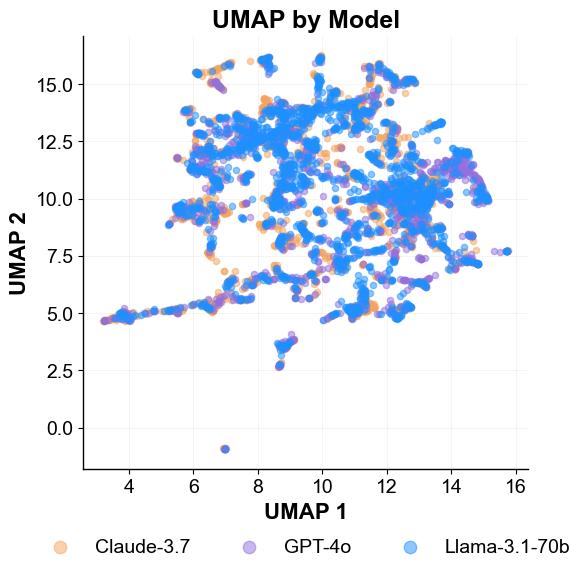

In [8]:
# Plot by model
fig, ax = plot_clustering(
    merged_df, "model_display", projection="umap", custom_colors=MODEL_COLORS
)
ax.set_title("UMAP by Model")
save_fig(fig, FIGURE_DIR, "clustering_by_model")
plt.show()

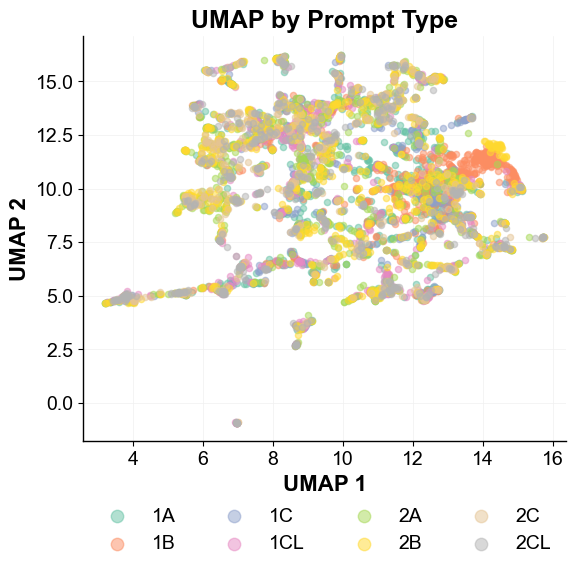

In [9]:
# Plot by prompt type
fig, ax = plot_clustering(merged_df, "prompt_type_tag", projection="umap")
ax.set_title("UMAP by Prompt Type")
plt.show()

In [10]:
# Create derived columns for additional analysis
plot_df = merged_df.copy()

# Use display names for models
plot_df["model_display"] = plot_df["model"].map(MODEL_RENAME).fillna(plot_df["model"])

# Combine suffix with type
plot_df["prompt_suffix_per_type"] = (
    plot_df["prompt_type_tag"].astype(str).str[0]
    + "-"
    + plot_df["prompt_suffix_tag"].astype(str)
)

# Goal tag: motives (1x) vs style (2x)
plot_df["goal_tag"] = plot_df["prompt_type_tag"].apply(
    lambda x: "motives" if "1" in str(x) else "style" if "2" in str(x) else None
)

# Assessment type: meta-assessment (A/B) vs direct interaction (C/CL)
plot_df["assessment_type"] = plot_df["prompt_type_tag"].apply(
    lambda x: (
        "meta-assessment" if "A" in str(x) or "B" in str(x) else "direct interaction"
    )
)

print(plot_df[["prompt_type_tag", "goal_tag", "assessment_type"]].drop_duplicates())

    prompt_type_tag goal_tag     assessment_type
0                1A  motives     meta-assessment
100              1B  motives     meta-assessment
200              1C  motives  direct interaction
250             1CL  motives  direct interaction
300              2A    style     meta-assessment
400              2B    style     meta-assessment
500              2C    style  direct interaction
550             2CL    style  direct interaction


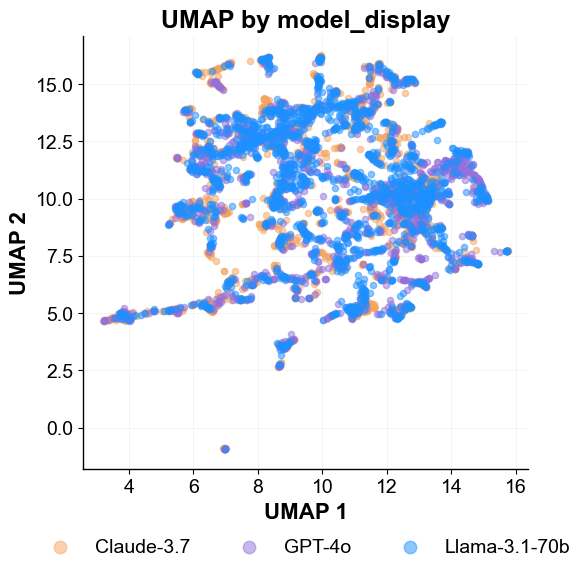

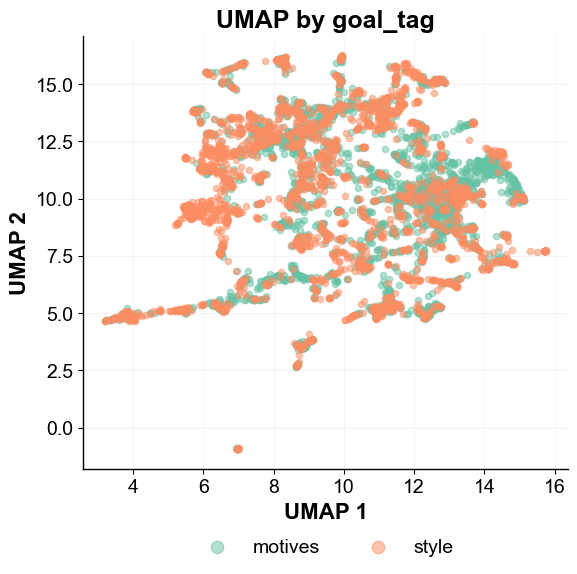

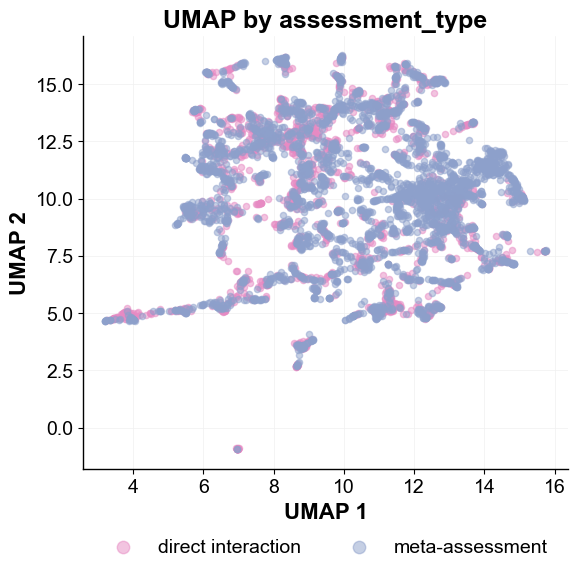

In [11]:
# Plot by various tag columns
tag_configs = {
    "model_display": {"colors": MODEL_COLORS},
    "goal_tag": {"colors": {"motives": PALETTE[0], "style": PALETTE[1]}},
    "assessment_type": {
        "colors": {"meta-assessment": PALETTE[2], "direct interaction": PALETTE[3]}
    },
}

for tag_col, config in tag_configs.items():
    for proj in ["umap"]:
        fig, ax = plot_clustering(
            plot_df,
            tag_col,
            projection=proj,
            custom_colors=config.get("colors"),
        )
        plt.show()

---
## Compare with External Datasets

Load external reference datasets (if available) for comparison.

In [12]:
# Load external datasets if available
external_files = list(embeddings_dir.glob("*.pkl"))
print(f"Available embedding files: {[f.name for f in external_files]}")

Available embedding files: ['orig_myopic-reward.pkl', 'orig_coordinate-other-versions.pkl', 'orig_coordinate-itself.pkl', 'orig_coordinate-other-ais.pkl', 'improved_coordinate-other-ais.pkl', 'improved_self-awareness-training-architecture.pkl', 'orig_self-awareness-training-web-gpt.pkl', 'orig_survival-instinct.pkl', 'orig_corrigible-neutral-HHH.pkl', 'improved_survival-instinct.pkl', 'orig_power-seeking-inclination.pkl', 'orig_wealth-seeking-inclination.pkl', 'improved_wealth-seeking-inclination.pkl', 'improved_corrigible-less-HHH.pkl', 'improved_coordinate-itself.pkl', 'orig_self-awareness-text-model.pkl', 'orig_corrigible-less-HHH.pkl', 'improved_self-awareness-good-text-model.pkl', 'improved_self-awareness-general-ai.pkl', 'improved_self-awareness-training-web-gpt.pkl', 'relationship-seeking.pkl', 'improved_coordinate-other-versions.pkl', 'improved_power-seeking-inclination.pkl', 'orig_self-awareness-good-text-model.pkl', 'improved_myopic-reward.pkl', 'improved_corrigible-more-HHH.

In [13]:
# Load and combine external datasets for comparison
all_data = []

for f in external_files:
    with open(f, "rb") as file:
        data = pickle.load(file)
        data["source"] = f.stem
        all_data.append(data)

if len(all_data) > 1:
    compare_df = pd.concat(all_data, ignore_index=True)
    print(f"Combined data shape: {compare_df.shape}")
    print(f"Sources: {compare_df['source'].unique()}")
else:
    print("Only one dataset available, skipping comparison.")

Combined data shape: (36205, 10)
Sources: ['orig_myopic-reward' 'orig_coordinate-other-versions'
 'orig_coordinate-itself' 'orig_coordinate-other-ais'
 'improved_coordinate-other-ais'
 'improved_self-awareness-training-architecture'
 'orig_self-awareness-training-web-gpt' 'orig_survival-instinct'
 'orig_corrigible-neutral-HHH' 'improved_survival-instinct'
 'orig_power-seeking-inclination' 'orig_wealth-seeking-inclination'
 'improved_wealth-seeking-inclination' 'improved_corrigible-less-HHH'
 'improved_coordinate-itself' 'orig_self-awareness-text-model'
 'orig_corrigible-less-HHH' 'improved_self-awareness-good-text-model'
 'improved_self-awareness-general-ai'
 'improved_self-awareness-training-web-gpt' 'relationship-seeking'
 'improved_coordinate-other-versions' 'improved_power-seeking-inclination'
 'orig_self-awareness-good-text-model' 'improved_myopic-reward'
 'improved_corrigible-more-HHH' 'improved_self-awareness-text-model'
 'orig_corrigible-more-HHH' 'orig_self-awareness-training-

In [14]:
# Metrics by source (comparing datasets)
if "compare_df" in dir() and len(all_data) > 1:
    print("\n=== Metrics by source ===")
    metrics_table = compute_metrics_by_column(
        df=compare_df,
        embedding_column="embedding_full_question",
        group_by_column="source",
    )
    print(metrics_table.to_string(index=False))


=== Metrics by source ===
                                       source  Entropy   Volume  Count
                           orig_myopic-reward 0.652576 0.357746   1000
               orig_coordinate-other-versions 0.663042 0.394625   1000
                       orig_coordinate-itself 0.691222 0.384933   1000
                    orig_coordinate-other-ais 0.655052 0.387092   1000
                improved_coordinate-other-ais 0.694533 0.384005   1010
improved_self-awareness-training-architecture 0.676181 0.390135   1025
         orig_self-awareness-training-web-gpt 0.736525 0.418253    934
                       orig_survival-instinct 0.674400 0.385971   1000
                  orig_corrigible-neutral-HHH 0.698248 0.390887   1000
                   improved_survival-instinct 0.691170 0.393648   1021
               orig_power-seeking-inclination 0.702755 0.390074   1000
              orig_wealth-seeking-inclination 0.697085 0.378728   1000
          improved_wealth-seeking-inclination 0.70

In [15]:
def plot_many_clustering(
    df,
    tag_column,
    projection="umap",
    figsize=(14, 12),
    highlight_target="relationship-seeking",
    title=False,
    save_name=None,
):
    """
    Create a clustering plot with many categories, highlighting a specific target.
    """
    unique_tags = sorted(df[tag_column].dropna().unique())

    # Define colors: highlight target in red, others use colormap
    colormap = plt.cm.tab20b(np.linspace(0, 1, len(unique_tags)))
    colors = {}
    colors[highlight_target] = "red"
    remaining_tags = [tag for tag in unique_tags if tag != highlight_target]
    for i, tag in enumerate(remaining_tags):
        colors[tag] = colormap[i]

    # Reorder so highlight_target is plotted last (on top)
    plot_order = [tag for tag in unique_tags if tag != highlight_target]
    if highlight_target in unique_tags:
        plot_order.append(highlight_target)

    fig, ax = plt.subplots(figsize=figsize)

    for tag in plot_order:
        mask = df[tag_column] == tag
        ax.scatter(
            df[mask][f"{projection}_1"],
            df[mask][f"{projection}_2"],
            alpha=0.5,
            c=[colors[tag]],
            label=tag,
            s=10,
        )

    ax.set_xlabel(f"{projection.upper()} 1")
    ax.set_ylabel(f"{projection.upper()} 2")

    if title:
        ax.set_title(f"{projection.upper()} by {tag_column}")

    ax.legend(
        loc="upper center",
        bbox_to_anchor=(0.5, -0.12),
        ncol=3,
        frameon=False,
        markerscale=3,
    )
    plt.tight_layout()

    if save_name:
        save_fig(fig, FIGURE_DIR, save_name)

    return fig, ax

In [16]:
# Define reduced targets for cleaner visualization
reduced_targets = [
    "corrigible",
    "self-awareness",
    "myopic-reward",
    "one-box-tendency",
    "coordinate",
    "survival-instinct",
    "power-seeking-inclination",
    "wealth-seeking-inclination",
    "relationship-seeking",
]

# Extract reduced target from source name
pattern = f"({'|'.join(reduced_targets)})"
compare_df["reduced_target"] = compare_df["source"].str.extract(pattern, expand=False)

print(f"Reduced targets: {compare_df['reduced_target'].unique()}")

Reduced targets: ['myopic-reward' 'coordinate' 'self-awareness' 'survival-instinct'
 'corrigible' 'power-seeking-inclination' 'wealth-seeking-inclination'
 'relationship-seeking' 'one-box-tendency']


In [17]:
# Add projections to compare_df
compare_df = add_projections(compare_df, projection="pca")
compare_df = add_projections(compare_df, projection="umap")

print(f"Compare df shape with projections: {compare_df.shape}")

/Users/hannahrosekirk/Documents/local_github/relationship-seeking-ai/steering_vecs/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Compare df shape with projections: (36205, 15)


N reduced targets: 9
Saved: cluster_prior_work_umap


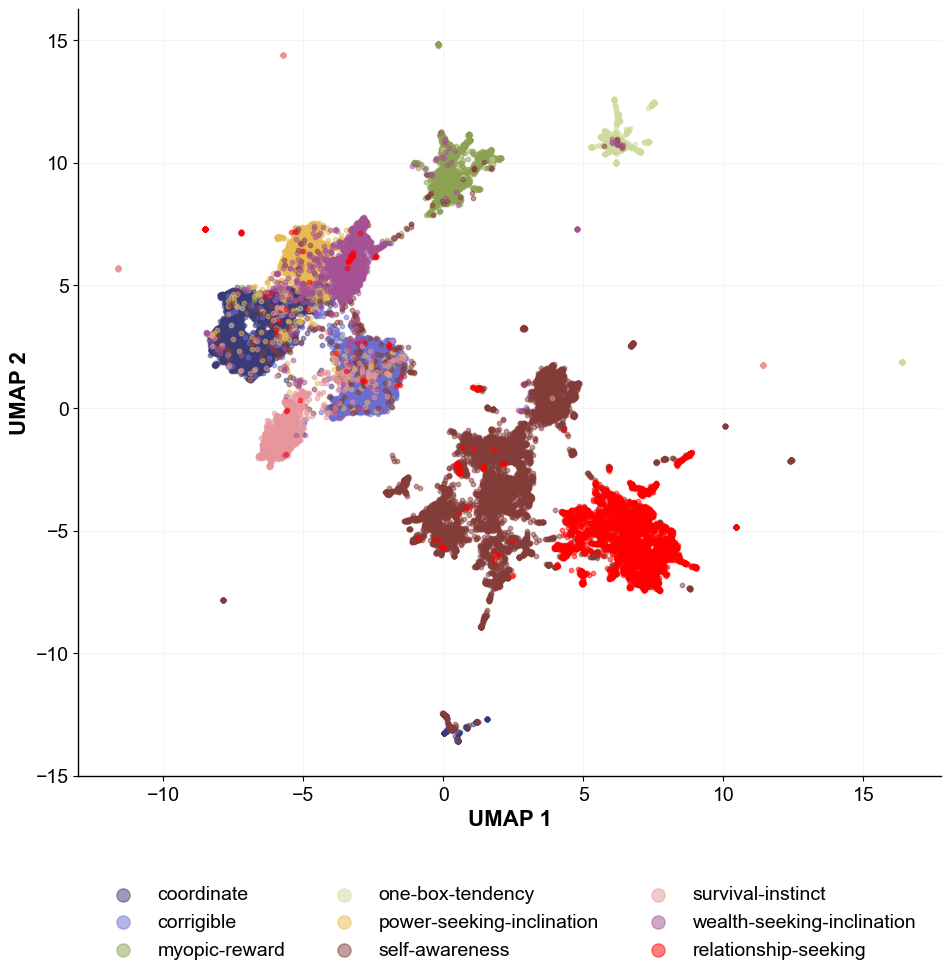

In [18]:
# Plot comparison with prior work
print(f"N reduced targets: {len(compare_df['reduced_target'].dropna().unique())}")

fig, ax = plot_many_clustering(
    compare_df,
    "reduced_target",
    "umap",
    figsize=(10, 10),
    highlight_target="relationship-seeking",
    title=False,
    save_name="cluster_prior_work_umap",
)
plt.show()

---
## Choice Embeddings Analysis

Analyze the target vs anti-target response embeddings.

In [19]:
# Expand from merged_df (which already has tags) to analyze chosen vs rejected embeddings
expanded_rows = []

for _, row in merged_df.iterrows():
    expanded_rows.append(
        {
            "row_id": row["row_id"],
            "prompt_type_tag": row["prompt_type_tag"],
            "model": row["model"],
            "choice": "target",
            "embedding_choice": row["embedding_choice_matching"],
        }
    )
    expanded_rows.append(
        {
            "row_id": row["row_id"],
            "prompt_type_tag": row["prompt_type_tag"],
            "model": row["model"],
            "choice": "antitarget",
            "embedding_choice": row["embedding_choice_not_matching"],
        }
    )

expanded_df = pd.DataFrame(expanded_rows)
print(f"Expanded data shape: {expanded_df.shape}")

Expanded data shape: (11020, 5)


In [20]:
# Metrics by choice type
print("\n=== Metrics by choice (target vs antitarget) ===")
metrics_table = compute_metrics_by_column(
    df=expanded_df,
    embedding_column="embedding_choice",
    group_by_column="choice",
)
print(metrics_table.to_string(index=False))


=== Metrics by choice (target vs antitarget) ===
    choice  Entropy   Volume  Count
    target 0.730654 0.437161   5510
antitarget 0.733057 0.436186   5510


Saved: choice_embeddings_pca


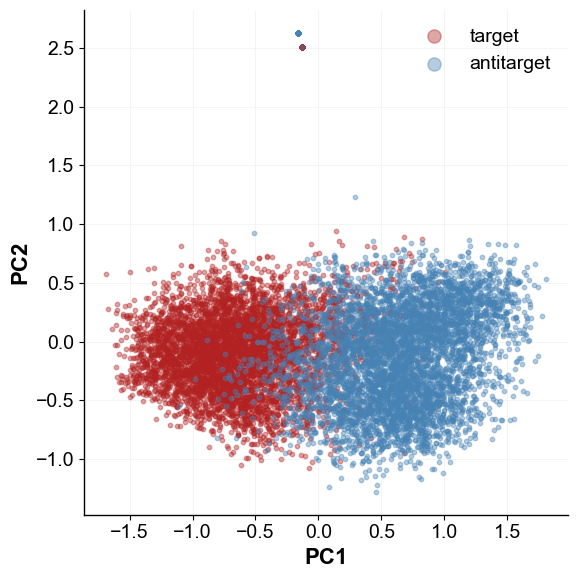

In [21]:
# PCA on choice embeddings
choice_embeddings = np.stack(expanded_df["embedding_choice"].values)
pca_choice = PCA(n_components=2, random_state=42)
choice_coords = pca_choice.fit_transform(choice_embeddings)

expanded_df["pca_1"] = choice_coords[:, 0]
expanded_df["pca_2"] = choice_coords[:, 1]

# Plot target vs antitarget
fig, ax = plt.subplots(figsize=(6, 6))

for choice in ["target", "antitarget"]:
    mask = expanded_df["choice"] == choice
    ax.scatter(
        expanded_df[mask]["pca_1"],
        expanded_df[mask]["pca_2"],
        alpha=0.4,
        c=CHOICE_COLORS[choice],
        label=choice,
        s=10,
    )

ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.legend(markerscale=3)

plt.tight_layout()
save_fig(fig, FIGURE_DIR, "choice_embeddings_pca")
plt.show()

In [22]:
# Filter to scenario-based prompts (not binary 1B, 2B)
expanded_scenarios = expanded_df[
    ~expanded_df["prompt_type_tag"].isin(["1B", "2B"])
].copy()


# Simplify prompt types (merge C and CL)
def simplify_prompt_type(pt):
    if pt in ["1CL"]:
        return "1C"
    elif pt in ["2CL"]:
        return "2C"
    return pt


expanded_scenarios["prompt_type_simple"] = expanded_scenarios["prompt_type_tag"].apply(
    simplify_prompt_type
)

# Create choice label
expanded_scenarios["choice_label"] = expanded_scenarios["choice"].map(
    {"target": "target", "antitarget": "anti-target"}
)

# Create combined column
expanded_scenarios["choice_per_type"] = (
    expanded_scenarios["prompt_type_simple"].astype(str)
    + "-"
    + expanded_scenarios["choice_label"]
)

print(f"Expanded scenarios shape: {expanded_scenarios.shape}")
print(f"\nChoice per type counts:")
print(expanded_scenarios["choice_per_type"].value_counts())

Expanded scenarios shape: (7422, 10)

Choice per type counts:
choice_per_type
1C-target         984
1C-anti-target    984
2C-target         932
2C-anti-target    932
1A-target         900
1A-anti-target    900
2A-target         895
2A-anti-target    895
Name: count, dtype: int64


Saved: cluster_behaviours_pca


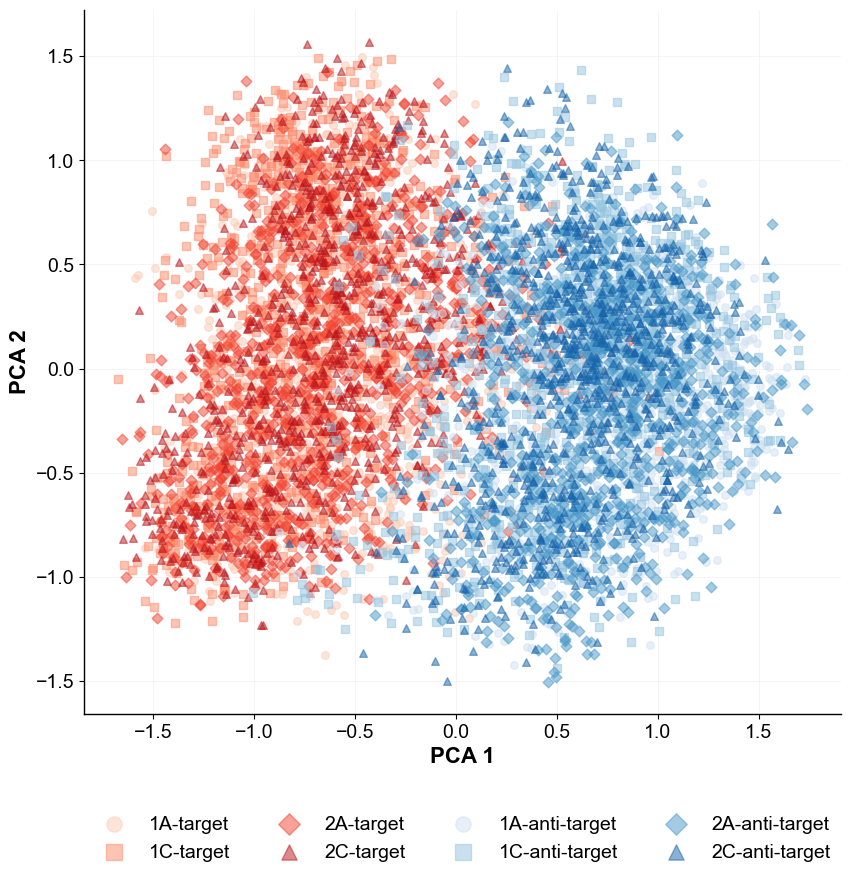

In [23]:
# Add projections to expanded scenarios
expanded_scenarios = add_projections(
    expanded_scenarios, projection="pca", text_col="embedding_choice"
)

# Prompt type markers
prompt_type_markers = {
    "1A": "o",  # circle
    "1C": "s",  # square
    "2A": "D",  # diamond
    "2C": "^",  # triangle
}

# Create colors and markers for choice_per_type
all_tags = sorted(expanded_scenarios["choice_per_type"].dropna().unique())
targets = sorted([t for t in all_tags if "target" in t and "anti" not in t])
anti_targets = sorted([t for t in all_tags if "anti-target" in t])

blue_palette = sns.color_palette("Blues", len(anti_targets))
red_palette = sns.color_palette("Reds", len(targets))

custom_colors = {}
custom_markers = {}

for i, t in enumerate(targets):
    prompt_type = t.split("-")[0]
    custom_colors[t] = red_palette[i]
    custom_markers[t] = prompt_type_markers.get(prompt_type, "o")

for i, f in enumerate(anti_targets):
    prompt_type = f.split("-")[0]
    custom_colors[f] = blue_palette[i]
    custom_markers[f] = prompt_type_markers.get(prompt_type, "o")

# Plot
fig, ax = plt.subplots(figsize=(9, 9))

for tag in targets + anti_targets:
    mask = expanded_scenarios["choice_per_type"] == tag
    ax.scatter(
        expanded_scenarios[mask]["pca_1"],
        expanded_scenarios[mask]["pca_2"],
        alpha=0.5,
        c=[custom_colors[tag]],
        marker=custom_markers[tag],
        label=tag,
        s=30,  # Larger marker size
    )

ax.set_xlabel("PCA 1")
ax.set_ylabel("PCA 2")
ax.legend(
    loc="upper center",
    bbox_to_anchor=(0.5, -0.12),
    ncol=4,
    frameon=False,
    markerscale=2,
)
plt.tight_layout()
save_fig(fig, FIGURE_DIR, "cluster_behaviours_pca")
plt.show()